<a href="https://colab.research.google.com/github/Warvito/vq-vae/blob/master/1%20-%20Autoregressive%20Models%20-%20PixelCNN/pixelCNN_w_4_levels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoregressive Models - PixelCNN

The autoregressive models are generative models that provides an explicit parametric specification of a likelihood function of a variable by specifying it with its parameters. However, to model data that have several dimensions/features, autoregressive models need to define some constraints. First, the observation space X need to have a determining ordering for its features. That is why autoregressive models are naturally used for time series that have a sequence of time steps. However, it can also be employed for images by defining, for example, that the pixels from left come before from the ones in the right, and the ones in the top before the ones in the bottom. Second, to tractably model the joint distribution of the features in a data observation (p(x)), the autoregressive approach cast p(x) as a product of conditional distributions. Autoregressive models define the joint distribution using conditionals over each feature given the values of the previous features. For example, the probability of a pixel from an image to have a specific value is conditioned by the values of all previous pixels; and the probability of an image (the joint distribution) is the combination of the probability of all its pixels. This way, autoregressive models use the chain rule to decompose the likelihood of the data sample x into a product of 1-dimensional distributions (Eq. 1). The factorization turns the joint modelling problem into a sequence problem, where one learns to predict the next pixel given all the previously generated pixels.

***IMAGE***

This is what mainly define an autoregressive model.

Now, the big challenge is how to represent these conditional this p(xi) that usually has a really complex distribution. How could we define it in an expressive model that are also tractable and scalable? One solution is using deep neural networks. 


## PixelCNN
PixelCNN was introduced by DeepMind in 2016 (Oord et al, 2016) and it started one of the most promising families of autoregressive generative models. PixelCNN is a deep neural network that captures the distribution of dependencies between pixels in the parameters. It sequentially generates one pixel at a time in an image along the two spatial dimensions. 



In this implementation, we used the new Tensorflow 2.0 framework. In the fisrt step we install and import the code dependencies.

In [ ]:
! pip3 install -U tensorflow-gpu

In [1]:
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.__version__

Then, we define the random seeds to have reproducible results and we load the MNIST dataset to train the PixelCNN.

In [3]:
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [4]:
# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

height = 28
width = 28
n_channel = 1

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, n_channel)
x_test = x_test.reshape(x_test.shape[0], height, width, n_channel)

In this example, to make the probability distribution of a single pixel easier to be defined, we decide to quantisise the number of possible values that a pixel could have. Originally, in the MNIST dataset the pixel are represented bya  a uint8 variable, beeing able assume values between [0, 255]. In this example, we restring the image to have only 4 different values ([0, 3]).

In [5]:
def quantise(images, q_levels):
    """Quantise image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')

In [6]:
# Quantise the input data in q levels
q_levels = 4
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

Using the tensorflow.Data API, we defined the input data streams for our model during the training and the evaluation. In these dataset, we define the inputs as the images with the 4 levels normaized to be between [0, 1] and the target values are the categoricals pixels values between [0, 3].

In [7]:
# Creating input stream using tf.data API
batch_size = 128
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

W1001 16:55:51.424210 140432253511488 deprecation.py:323] From /media/kcl_1/HDD/PycharmProjects/vq-vae/venv/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Masked Convolutions

When using the convolution operations, PixelCNN can parallelly learn the distribution of all pixels in the image. However, the receptive field of a standard convolutional violates the sequential prediction of autoregressive models. When processing the data of a central pixel, the convolutional filter considers all the pixels around it to calculate the output feature map, not only the previous pixels. 

To solve this problem, masks are adopted block information flow from the future pixels.

Masking can be done by zeroing out all the pixels that should not be considered. In our implementation, a mask with the same size to the convolutional filter with values 1 and 0 was created. This mask was multiplied with the weight tensor before doing the convolution operation.

In the pixelCNN, there are two types of masks: type A and type B.

*	Mask A: this mask is applied only to the first convolutional layer. It restricts to access to the pixel of interest by zeroing the center pixel in mask. This way, we guarantee model will not access the pixel that it is about to predict. 

*	Mask B: This mask is applied to all the subsequent convolutional layers and relaxes the restrictions of mask A by allowing the connection from a pixel to itself. 

Below, we have the masks defined inside a keras layer named MasekdConv2D. In this layer, besides the parameters weigths and bias, we have the constant mask defininng the pixels to be zeroed and the type of mask (A or B) (Lines 41 to 47).

Finally, the mask is applied before the convolution (Line 50).


In [8]:
class MaskedConv2D(tf.keras.layers.Layer):
    """Convolutional layers with masks for autoregressive models

    Convolutional layers with simple implementation to have masks type A and B.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B'}
        self.mask_type = mask_type

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=(self.kernel_size,
                                             self.kernel_size,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight("bias",
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        mask = np.ones(self.kernel.shape, dtype=np.float32)
        mask[self.kernel_size // 2, self.kernel_size // 2 + (self.mask_type == 'B'):, :, :] = 0.
        mask[self.kernel_size // 2 + 1:, :, :] = 0.

        self.mask = tf.constant(mask, dtype=tf.float32, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = tf.nn.conv2d(input, masked_kernel, strides=[1, self.strides, self.strides, 1], padding=self.padding)
        x = tf.nn.bias_add(x, self.bias)
        return x

## Residual blocks

Another element that compose the PixelCNN architecture is the residual blocks.

In [9]:
class ResidualBlock(tf.keras.Model):
    """Residual blocks that compose pixelCNN

    Blocks of layers with 3 convolutional layers and one residual connection.
    Based on Figure 5 from [1] where h indicates number of filters.

    Refs:
    [1] - Oord, A. V. D., Kalchbrenner, N., & Kavukcuoglu, K. (2016). Pixel
     recurrent neural networks. arXiv preprint arXiv:1601.06759.
    """

    def __init__(self, h):
        super(ResidualBlock, self).__init__(name='')

        self.conv2a = keras.layers.Conv2D(filters=h, kernel_size=1, strides=1)
        self.conv2b = MaskedConv2D(mask_type='B', filters=h, kernel_size=3, strides=1)
        self.conv2c = keras.layers.Conv2D(filters=2 * h, kernel_size=1, strides=1)

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv2a(x)

        x = tf.nn.relu(x)
        x = self.conv2b(x)

        x = tf.nn.relu(x)
        x = self.conv2c(x)

        x += input_tensor
        return x

## PixelCNN architecture

In Oord et al. 2016, the PixelCNN uses the following architecture (Figure X):

**FIGURA**

the first layer is a masked convolution (type A) with 7x7 filters. Then, 15 residuals blocks were used. Each block process the data with a combination of 3x3 layers convolutional layers with mask type B and 1x1 standard convolutional layers. Between each convolutional layer there is also a non-linearity ReLU. After these layers, a residual connection is added. Finally, the network has a sequence of RELU-CONV-RELU-CONV using standard convolutional layers, where both have 1x1 filters. Then, the output layer is a softmax layer which predicts the value among all possible values of a pixel. So, this softmax layer had the image dimension (because we want an output value for each pixel) times the number of possible values (for example, 256 pixels values).

In [10]:
# Create PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=128, kernel_size=7, strides=1)(inputs)

for i in range(15):
    x = ResidualBlock(h=64)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Conv2D(filters=n_channel * q_levels, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

In this implementation we use a simple Adam optimizer with learning rate decay to train the neural network. The loss function is defined by the crossentropy (that in this case is equivalent to minimizing the negative log-likelihood of the training data).

In [11]:
# Prepare optimizer and loss function
lr_decay = 0.9999
learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

The training step is defined by the forward propagation throgh the model, and then the outputs are reshaped to work with several inputs channels (like RGB channels). Finally, the gradients are calculated, clipped to be between [-1, 1], and applied to upgrade the PixelCNN parameters.

In [12]:
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])  # shape [N,H,W,DC] -> [N,H,W,D,C]
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])  # shape [N,H,W,D,C] -> [N,H,W,C,D]

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

In this implementation, we defined the trainig loop with 30 epochs.

In [13]:
# Training loop
n_epochs = 100
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    start_epoch = time.time()
    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)
        iter_time = time.time() - start
        if i_iter % 100 == 0:
            print('EPOCH {:3d}: ITER {:4d}/{:4d} TIME: {:.2f} LOSS: {:.4f}'.format(epoch,
                                                                                   i_iter, n_iter,
                                                                                   iter_time,
                                                                                   loss))
    epoch_time = time.time() - start_epoch
    print('EPOCH {:3d}: TIME: {:.2f} ETA: {:.2f}'.format(epoch,
                                                         epoch_time,
                                                         epoch_time * (n_epochs - epoch)))


EPOCH   0: ITER    0/ 469 TIME: 6.14 LOSS: 1.3942
EPOCH   0: ITER  100/ 469 TIME: 0.13 LOSS: 0.1720
EPOCH   0: ITER  200/ 469 TIME: 0.13 LOSS: 0.1597
EPOCH   0: ITER  300/ 469 TIME: 0.13 LOSS: 0.1494
EPOCH   0: ITER  400/ 469 TIME: 0.13 LOSS: 0.1495
EPOCH   0: TIME: 70.63 ETA: 7062.60
EPOCH   1: ITER    0/ 469 TIME: 0.07 LOSS: 0.1516
EPOCH   1: ITER  100/ 469 TIME: 0.13 LOSS: 0.1504
EPOCH   1: ITER  200/ 469 TIME: 0.13 LOSS: 0.1486
EPOCH   1: ITER  300/ 469 TIME: 0.13 LOSS: 0.1419
EPOCH   1: ITER  400/ 469 TIME: 0.13 LOSS: 0.1447
EPOCH   1: TIME: 61.88 ETA: 6126.58
EPOCH   2: ITER    0/ 469 TIME: 0.06 LOSS: 0.1477
EPOCH   2: ITER  100/ 469 TIME: 0.13 LOSS: 0.1455
EPOCH   2: ITER  200/ 469 TIME: 0.13 LOSS: 0.1461
EPOCH   2: ITER  300/ 469 TIME: 0.13 LOSS: 0.1398
EPOCH   2: ITER  400/ 469 TIME: 0.13 LOSS: 0.1426
EPOCH   2: TIME: 62.08 ETA: 6084.18
EPOCH   3: ITER    0/ 469 TIME: 0.07 LOSS: 0.1456
EPOCH   3: ITER  100/ 469 TIME: 0.13 LOSS: 0.1442
EPOCH   3: ITER  200/ 469 TIME: 0.13 LOSS:

EPOCH  28: ITER  400/ 469 TIME: 0.13 LOSS: 0.1337
EPOCH  28: TIME: 62.72 ETA: 4515.76
EPOCH  29: ITER    0/ 469 TIME: 0.07 LOSS: 0.1363
EPOCH  29: ITER  100/ 469 TIME: 0.13 LOSS: 0.1340
EPOCH  29: ITER  200/ 469 TIME: 0.13 LOSS: 0.1336
EPOCH  29: ITER  300/ 469 TIME: 0.13 LOSS: 0.1293
EPOCH  29: ITER  400/ 469 TIME: 0.13 LOSS: 0.1336
EPOCH  29: TIME: 62.71 ETA: 4452.15
EPOCH  30: ITER    0/ 469 TIME: 0.07 LOSS: 0.1359
EPOCH  30: ITER  100/ 469 TIME: 0.13 LOSS: 0.1340
EPOCH  30: ITER  200/ 469 TIME: 0.13 LOSS: 0.1336
EPOCH  30: ITER  300/ 469 TIME: 0.13 LOSS: 0.1290
EPOCH  30: ITER  400/ 469 TIME: 0.13 LOSS: 0.1334
EPOCH  30: TIME: 62.70 ETA: 4389.29
EPOCH  31: ITER    0/ 469 TIME: 0.07 LOSS: 0.1358
EPOCH  31: ITER  100/ 469 TIME: 0.13 LOSS: 0.1339
EPOCH  31: ITER  200/ 469 TIME: 0.13 LOSS: 0.1337
EPOCH  31: ITER  300/ 469 TIME: 0.13 LOSS: 0.1288
EPOCH  31: ITER  400/ 469 TIME: 0.13 LOSS: 0.1335
EPOCH  31: TIME: 62.66 ETA: 4323.61
EPOCH  32: ITER    0/ 469 TIME: 0.07 LOSS: 0.1358
EPOCH 

EPOCH  57: ITER  200/ 469 TIME: 0.13 LOSS: 0.1308
EPOCH  57: ITER  300/ 469 TIME: 0.14 LOSS: 0.1266
EPOCH  57: ITER  400/ 469 TIME: 0.13 LOSS: 0.1300
EPOCH  57: TIME: 62.63 ETA: 2692.94
EPOCH  58: ITER    0/ 469 TIME: 0.07 LOSS: 0.1325
EPOCH  58: ITER  100/ 469 TIME: 0.13 LOSS: 0.1311
EPOCH  58: ITER  200/ 469 TIME: 0.13 LOSS: 0.1306
EPOCH  58: ITER  300/ 469 TIME: 0.13 LOSS: 0.1264
EPOCH  58: ITER  400/ 469 TIME: 0.13 LOSS: 0.1299
EPOCH  58: TIME: 62.76 ETA: 2635.89
EPOCH  59: ITER    0/ 469 TIME: 0.07 LOSS: 0.1324
EPOCH  59: ITER  100/ 469 TIME: 0.13 LOSS: 0.1310
EPOCH  59: ITER  200/ 469 TIME: 0.13 LOSS: 0.1307
EPOCH  59: ITER  300/ 469 TIME: 0.13 LOSS: 0.1264
EPOCH  59: ITER  400/ 469 TIME: 0.13 LOSS: 0.1296
EPOCH  59: TIME: 62.73 ETA: 2572.12
EPOCH  60: ITER    0/ 469 TIME: 0.07 LOSS: 0.1323
EPOCH  60: ITER  100/ 469 TIME: 0.13 LOSS: 0.1310
EPOCH  60: ITER  200/ 469 TIME: 0.13 LOSS: 0.1305
EPOCH  60: ITER  300/ 469 TIME: 0.13 LOSS: 0.1263
EPOCH  60: ITER  400/ 469 TIME: 0.13 LOSS:

EPOCH  86: ITER    0/ 469 TIME: 0.07 LOSS: 0.1311
EPOCH  86: ITER  100/ 469 TIME: 0.13 LOSS: 0.1295
EPOCH  86: ITER  200/ 469 TIME: 0.13 LOSS: 0.1291
EPOCH  86: ITER  300/ 469 TIME: 0.13 LOSS: 0.1255
EPOCH  86: ITER  400/ 469 TIME: 0.13 LOSS: 0.1283
EPOCH  86: TIME: 62.84 ETA: 879.76
EPOCH  87: ITER    0/ 469 TIME: 0.07 LOSS: 0.1311
EPOCH  87: ITER  100/ 469 TIME: 0.13 LOSS: 0.1295
EPOCH  87: ITER  200/ 469 TIME: 0.13 LOSS: 0.1290
EPOCH  87: ITER  300/ 469 TIME: 0.13 LOSS: 0.1255
EPOCH  87: ITER  400/ 469 TIME: 0.13 LOSS: 0.1282
EPOCH  87: TIME: 62.57 ETA: 813.46
EPOCH  88: ITER    0/ 469 TIME: 0.07 LOSS: 0.1311
EPOCH  88: ITER  100/ 469 TIME: 0.13 LOSS: 0.1295
EPOCH  88: ITER  200/ 469 TIME: 0.13 LOSS: 0.1289
EPOCH  88: ITER  300/ 469 TIME: 0.13 LOSS: 0.1254
EPOCH  88: ITER  400/ 469 TIME: 0.13 LOSS: 0.1282
EPOCH  88: TIME: 62.68 ETA: 752.11
EPOCH  89: ITER    0/ 469 TIME: 0.07 LOSS: 0.1311
EPOCH  89: ITER  100/ 469 TIME: 0.13 LOSS: 0.1295
EPOCH  89: ITER  200/ 469 TIME: 0.13 LOSS: 0.

To evaluate the performance of the model, we measured the NLL of the model in the test set. 

In [14]:
# Test
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = pixelcnn(batch_x, training=False)
    logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
    logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / (height * width)))

nll : 0.14119678735733032 nats
bits/dim : 0.00018009794305781928


Finally, we sampled some images from the trained model. First, we sampled from the scratch, then we completed imaged partially occluded.

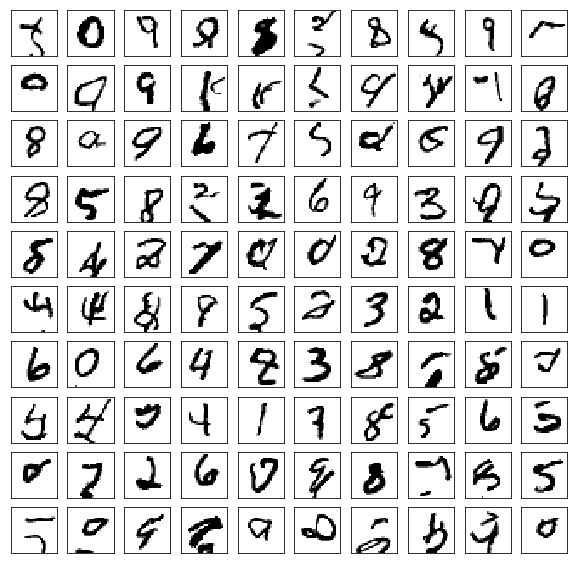

In [15]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
samples = np.zeros((100, height, width, n_channel), dtype='float32')
for i in range(height):
    for j in range(width):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        next_sample = tf.random.categorical(logits[:, i, j, 0, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:,0]

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

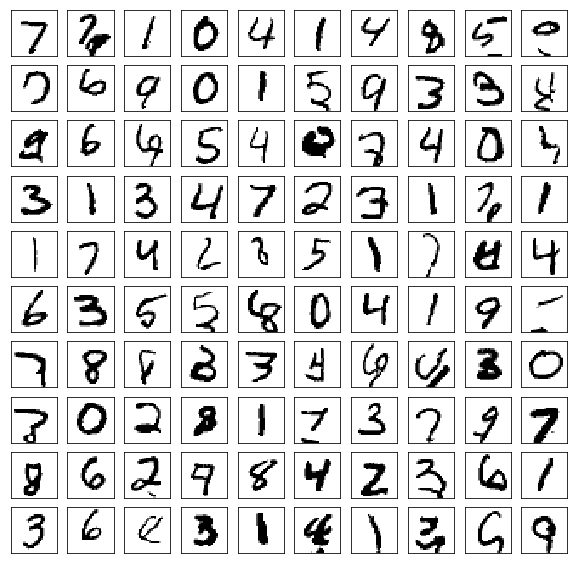

In [16]:
# --------------------------------------------------------------------------------------------------------------
# Filling occluded images
occlude_start_row = 14
num_generated_images = 100
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

for i in range(occlude_start_row, height):
    for j in range(width):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        next_sample = tf.random.categorical(logits[:, i, j, 0, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:,0]

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

That's looks great, so now let's check with 256 levels.

In [19]:
# --------------------------------------------------------------------------------------------------------------
# Quantise the input data in q levels
q_levels = 256
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

# --------------------------------------------------------------------------------------------------------------
# Creating input stream using tf.data API
batch_size = 128
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

# --------------------------------------------------------------------------------------------------------------
# Create PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=128, kernel_size=7, strides=1)(inputs)

for i in range(15):
    x = ResidualBlock(h=64)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=n_channel * q_levels, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)
# --------------------------------------------------------------------------------------------------------------
# Prepare optimizer and loss function
lr_decay = 0.9999
learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# --------------------------------------------------------------------------------------------------------------
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

# --------------------------------------------------------------------------------------------------------------
# Training loop
n_epochs = 100
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    start_epoch = time.time()
    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)
        iter_time = time.time() - start
        if i_iter % 100 == 0:
            print('EPOCH {:3d}: ITER {:4d}/{:4d} TIME: {:.2f} LOSS: {:.4f}'.format(epoch,
                                                                                   i_iter, n_iter,
                                                                                   iter_time,
                                                                                   loss))
    epoch_time = time.time() - start_epoch
    print('EPOCH {:3d}: TIME: {:.2f} ETA: {:.2f}'.format(epoch,
                                                         epoch_time,
                                                         epoch_time * (n_epochs - epoch)))
# --------------------------------------------------------------------------------------------------------------
# Test
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = pixelcnn(batch_x, training=False)
    logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
    logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / (height * width)))


EPOCH   0: ITER    0/ 469 TIME: 5.63 LOSS: 5.5472
EPOCH   0: ITER  100/ 469 TIME: 0.14 LOSS: 0.8145
EPOCH   0: ITER  200/ 469 TIME: 0.14 LOSS: 0.7960
EPOCH   0: ITER  300/ 469 TIME: 0.14 LOSS: 0.7949
EPOCH   0: ITER  400/ 469 TIME: 0.14 LOSS: 0.8190
EPOCH   0: TIME: 74.61 ETA: 7460.66
EPOCH   1: ITER    0/ 469 TIME: 0.07 LOSS: 0.7563
EPOCH   1: ITER  100/ 469 TIME: 0.14 LOSS: 0.7610
EPOCH   1: ITER  200/ 469 TIME: 0.14 LOSS: 0.7447
EPOCH   1: ITER  300/ 469 TIME: 0.14 LOSS: 0.7664
EPOCH   1: ITER  400/ 469 TIME: 0.14 LOSS: 0.7820
EPOCH   1: TIME: 66.64 ETA: 6597.70
EPOCH   2: ITER    0/ 469 TIME: 0.07 LOSS: 0.7320
EPOCH   2: ITER  100/ 469 TIME: 0.14 LOSS: 0.7430
EPOCH   2: ITER  200/ 469 TIME: 0.14 LOSS: 0.7348
EPOCH   2: ITER  300/ 469 TIME: 0.14 LOSS: 0.7479
EPOCH   2: ITER  400/ 469 TIME: 0.14 LOSS: 0.7662
EPOCH   2: TIME: 66.83 ETA: 6549.81
EPOCH   3: ITER    0/ 469 TIME: 0.07 LOSS: 0.7176
EPOCH   3: ITER  100/ 469 TIME: 0.14 LOSS: 0.7192
EPOCH   3: ITER  200/ 469 TIME: 0.14 LOSS:

EPOCH  28: ITER  400/ 469 TIME: 0.14 LOSS: 0.6494
EPOCH  28: TIME: 66.77 ETA: 4807.11
EPOCH  29: ITER    0/ 469 TIME: 0.07 LOSS: 0.6110
EPOCH  29: ITER  100/ 469 TIME: 0.14 LOSS: 0.6317
EPOCH  29: ITER  200/ 469 TIME: 0.14 LOSS: 0.6485
EPOCH  29: ITER  300/ 469 TIME: 0.14 LOSS: 0.6274
EPOCH  29: ITER  400/ 469 TIME: 0.14 LOSS: 0.6483
EPOCH  29: TIME: 66.75 ETA: 4739.51
EPOCH  30: ITER    0/ 469 TIME: 0.07 LOSS: 0.6197
EPOCH  30: ITER  100/ 469 TIME: 0.14 LOSS: 0.6217
EPOCH  30: ITER  200/ 469 TIME: 0.14 LOSS: 0.6310
EPOCH  30: ITER  300/ 469 TIME: 0.14 LOSS: 0.6263
EPOCH  30: ITER  400/ 469 TIME: 0.14 LOSS: 0.6397
EPOCH  30: TIME: 66.78 ETA: 4674.42
EPOCH  31: ITER    0/ 469 TIME: 0.07 LOSS: 0.6090
EPOCH  31: ITER  100/ 469 TIME: 0.14 LOSS: 0.6374
EPOCH  31: ITER  200/ 469 TIME: 0.14 LOSS: 0.6804
EPOCH  31: ITER  300/ 469 TIME: 0.14 LOSS: 0.6387
EPOCH  31: ITER  400/ 469 TIME: 0.14 LOSS: 0.6383
EPOCH  31: TIME: 66.88 ETA: 4614.39
EPOCH  32: ITER    0/ 469 TIME: 0.07 LOSS: 0.6037
EPOCH 

EPOCH  57: ITER  200/ 469 TIME: 0.14 LOSS: 0.6035
EPOCH  57: ITER  300/ 469 TIME: 0.14 LOSS: 0.6009
EPOCH  57: ITER  400/ 469 TIME: 0.14 LOSS: 0.6163
EPOCH  57: TIME: 66.73 ETA: 2869.28
EPOCH  58: ITER    0/ 469 TIME: 0.07 LOSS: 0.5881
EPOCH  58: ITER  100/ 469 TIME: 0.14 LOSS: 0.5898
EPOCH  58: ITER  200/ 469 TIME: 0.14 LOSS: 0.6015
EPOCH  58: ITER  300/ 469 TIME: 0.14 LOSS: 0.5955
EPOCH  58: ITER  400/ 469 TIME: 0.14 LOSS: 0.6146
EPOCH  58: TIME: 66.81 ETA: 2805.96
EPOCH  59: ITER    0/ 469 TIME: 0.07 LOSS: 0.5832
EPOCH  59: ITER  100/ 469 TIME: 0.14 LOSS: 0.5885
EPOCH  59: ITER  200/ 469 TIME: 0.14 LOSS: 0.6012
EPOCH  59: ITER  300/ 469 TIME: 0.14 LOSS: 0.5964
EPOCH  59: ITER  400/ 469 TIME: 0.14 LOSS: 0.6145
EPOCH  59: TIME: 66.79 ETA: 2738.49
EPOCH  60: ITER    0/ 469 TIME: 0.07 LOSS: 0.5815
EPOCH  60: ITER  100/ 469 TIME: 0.14 LOSS: 0.5851
EPOCH  60: ITER  200/ 469 TIME: 0.14 LOSS: 0.5984
EPOCH  60: ITER  300/ 469 TIME: 0.14 LOSS: 0.5923
EPOCH  60: ITER  400/ 469 TIME: 0.14 LOSS:

EPOCH  86: ITER    0/ 469 TIME: 0.07 LOSS: 0.5740
EPOCH  86: ITER  100/ 469 TIME: 0.14 LOSS: 0.5801
EPOCH  86: ITER  200/ 469 TIME: 0.14 LOSS: 0.5931
EPOCH  86: ITER  300/ 469 TIME: 0.14 LOSS: 0.5867
EPOCH  86: ITER  400/ 469 TIME: 0.14 LOSS: 0.6068
EPOCH  86: TIME: 66.72 ETA: 934.12
EPOCH  87: ITER    0/ 469 TIME: 0.07 LOSS: 0.5740
EPOCH  87: ITER  100/ 469 TIME: 0.14 LOSS: 0.5801
EPOCH  87: ITER  200/ 469 TIME: 0.14 LOSS: 0.5930
EPOCH  87: ITER  300/ 469 TIME: 0.14 LOSS: 0.5870
EPOCH  87: ITER  400/ 469 TIME: 0.14 LOSS: 0.6066
EPOCH  87: TIME: 66.83 ETA: 868.82
EPOCH  88: ITER    0/ 469 TIME: 0.07 LOSS: 0.5737
EPOCH  88: ITER  100/ 469 TIME: 0.14 LOSS: 0.5797
EPOCH  88: ITER  200/ 469 TIME: 0.14 LOSS: 0.5927
EPOCH  88: ITER  300/ 469 TIME: 0.14 LOSS: 0.5873
EPOCH  88: ITER  400/ 469 TIME: 0.14 LOSS: 0.6067
EPOCH  88: TIME: 66.72 ETA: 800.59
EPOCH  89: ITER    0/ 469 TIME: 0.07 LOSS: 0.5740
EPOCH  89: ITER  100/ 469 TIME: 0.14 LOSS: 0.5807
EPOCH  89: ITER  200/ 469 TIME: 0.14 LOSS: 0.

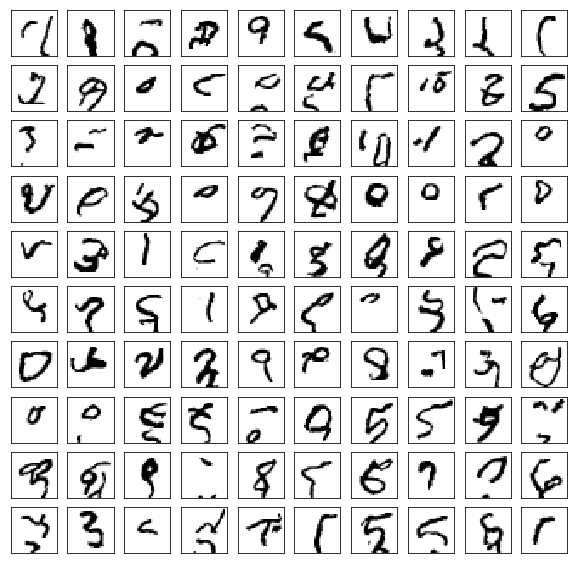

In [20]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
samples = np.zeros((100, height, width, n_channel), dtype='float32')
for i in range(height):
    for j in range(width):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        next_sample = tf.random.categorical(logits[:, i, j, 0, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:,0]

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()


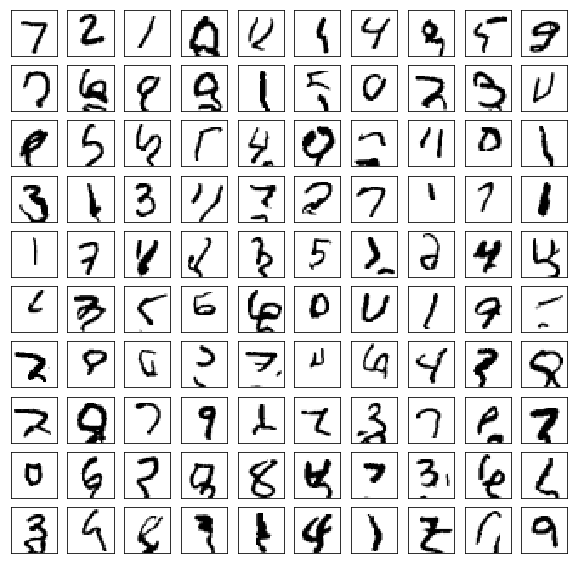

In [21]:
# --------------------------------------------------------------------------------------------------------------
# Filling occluded images
occlude_start_row = 14
num_generated_images = 100
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

for i in range(occlude_start_row, height):
    for j in range(width):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        next_sample = tf.random.categorical(logits[:, i, j, 0, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:,0]

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()
